In [1]:
# I used this notebook as reference
# https://www.kaggle.com/code/keitazoumana/scientific-document-similarity-search-with-scibert/notebook

In [2]:
import torch
from transformers import BertTokenizer,  AutoModelForSequenceClassification
%run -i "../utils.py"

pretrained_model = 'allenai/scibert_scivocab_uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model, do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, output_attentions=False, output_hidden_states=True)

C:\Users\lbeln\anaconda3\envs\3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from keras.preprocessing.sequence import pad_sequences

def embed(string, verbose=False):
    input_ids = tokenizer.encode(string, add_special_tokens=True)
    if verbose:
        print(f"Input IDs: {[input_ids]}")
    padded_input_ids = pad_sequences([input_ids], maxlen=210, dtype="long", truncating="post", padding="post")
    if verbose:
        print(f"Padded Input IDs: {[padded_input_ids]}")
    
    input_ids = padded_input_ids[0]
    if verbose:
        print(f"Input IDs: {[input_ids]}")

    # Attention Mask
    # It seems that it holds boolean values.
    attention_mask = [int(i > 0) for i in input_ids]
    
    # Convert to Tensors
    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    
    # Pseudo-Batch
    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)
    
    model.eval()
    
    # Run the text through BERT, and collect all of the hidden states produced
    # from all 12 layers. 
    with torch.no_grad():        
        logits, encoded_layers = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, return_dict=False)

    layer_i = 12 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]
        
    # Extract the embedding.
    embedding = encoded_layers[layer_i][batch_i][token_i]
    embedding = embedding.detach().cpu().numpy()

    if verbose:
        print(f"Embedding Shape: {embedding.shape}")
    return (embedding)

In [4]:
def add_embeddings(data):
    data = data.copy()
    embeddings = []
    for abstract in data.Abstract:
        embeddings.append(embed(abstract))
    data["Embeddings"] = embeddings
    return data

def process_embedding(embedding, verbose=False):
    if verbose:
        print(f"Shape: {embedding.shape}")
    # The embedding needs to be a row vector
    # for the cosine similarity calculation.
    # I think, I might have misremembered.
    embedding = np.array(embedding)
    embedding = embedding.reshape(1, -1)
    if verbose:
        print(f"Shape: {embedding.shape}")
    return embedding

In [17]:
from sklearn.neighbors import NearestNeighbors
import pickle
import numpy as np
import pandas as pd

def score_dataset(name, n_neighbors=2, p=2, mean=False, verbose=False):
    # Load Dataset
    data = load_preprocessed_dataset(name)

    if data.shape[0] == 0:
        print("Nothing to Score")
        return

    # Add Embeddings (from Abstract)
    data = add_embeddings(data)
    
    # Load Examples
    # These are the abstracts that the papers will be scored against
    # (in terms of similarity).
    with open(f"../../Datasets/Examples.pkl", "rb") as f: 
        examples = pickle.load(f)

    if verbose:
        print(f"Examples Shape: {examples.shape}")

    # Add Embeddings
    # Embeddings are vectors that represent real-world objects, like words, images, 
    # or videos, in a form that machine learning models can easily process.
    # (CloudFlare)
    # The idea that I have in mind is to compare each paper to the examples.
    # So, the examples would make be used here as the neighbors. It's pretty similar
    # to the cosine similarity method.
    examples = add_embeddings(examples)
    example_embeddings = np.stack(examples.Embeddings.to_numpy())
    if verbose:
        print(f"Example Embeddings Shape: {example_embeddings.shape}")
    
    neighbors = NearestNeighbors(n_neighbors=n_neighbors, p=p, algorithm='ball_tree').fit(example_embeddings)
    
    data["Distances"] = data["Embeddings"].apply(lambda x: neighbors.kneighbors(process_embedding(x))[0])
    if mean:
        data["Score"] = data["Distances"].apply(lambda x: np.mean(x))
    else:
        data["Score"] = data["Distances"].apply(lambda x: np.min(x))
        
    # The lower the score the better, since we're looking for papers that are closer (in distance) to the example papers
    data.sort_values(by='Score', ascending=True, inplace=True)
    return data

In [18]:
# Score Datasets
for n in [1, 2, 3, 4]:
    for p in [1, 2]:
        scored_data = score_dataset("Baseline-1", n_neighbors=n, p=p, mean=True, verbose=False)
        store_scored_dataset(scored_data, "Baseline-1", version=f'N{n}P{p}')

dataset_names = ["Examples", "Baseline-1", "SubA", "SubAFiltered", "SubB", "SubBFiltered", "C", "CFiltered", "D", "DFiltered"]
for name in dataset_names:
    if name == "Baseline-1":
        continue
    scored_data = score_dataset(name, n_neighbors=2, p=2, mean=True, verbose=False)
    store_scored_dataset(scored_data, name, version='')

Data Shape: (28, 4)
Data Shape: (28, 4)
Data Shape: (28, 4)
Data Shape: (28, 4)
Data Shape: (28, 4)
Data Shape: (28, 4)
Data Shape: (28, 4)
Data Shape: (28, 4)
Data Shape: (4, 4)
Data Shape: (150, 4)
Data Shape: (4, 4)
Data Shape: (150, 4)
Data Shape: (3, 4)
Data Shape: (6, 4)
Data Shape: (4, 4)
Data Shape: (153, 4)
Data Shape: (52, 4)


[N=4, P=1] Accuracy: 70.37%


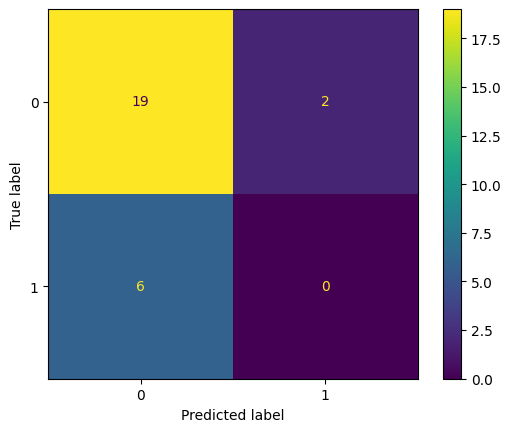

[N=3, P=1] Accuracy: 48.15%


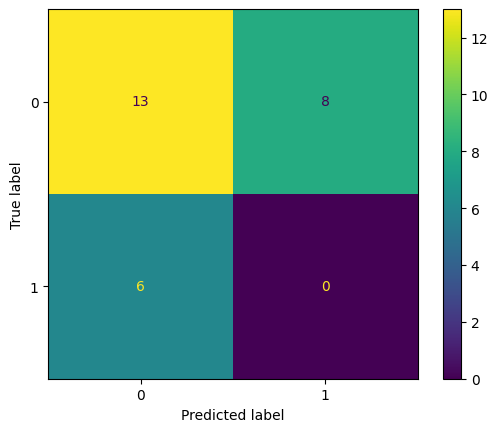

[N=2, P=1] Accuracy: 37.04%


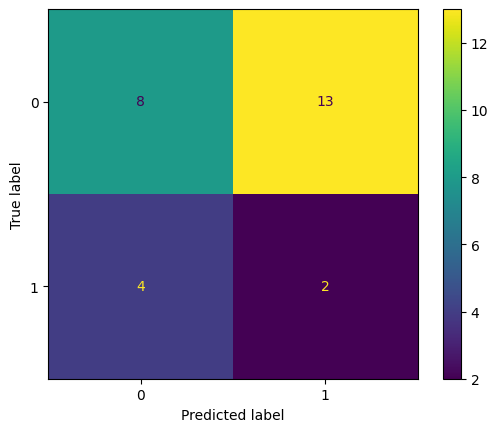

[N=3, P=2] Accuracy: 37.04%


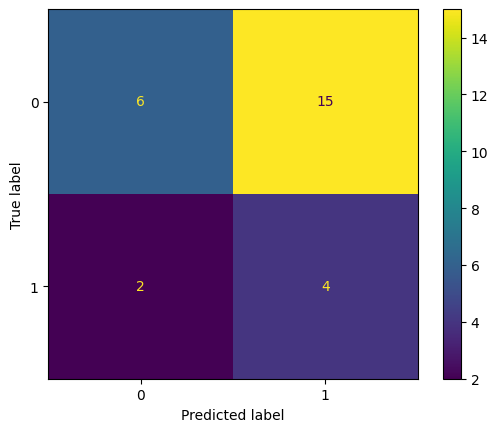

[N=4, P=2] Accuracy: 33.33%


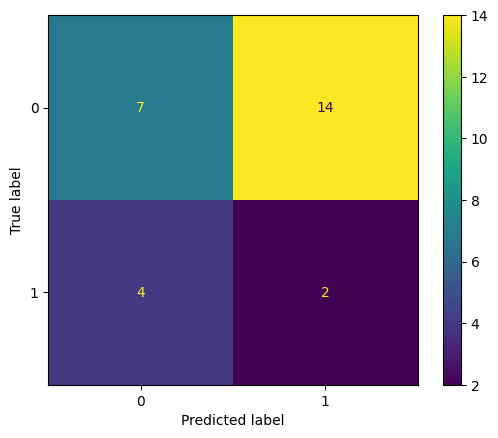

[N=1, P=1] Accuracy: 25.93%


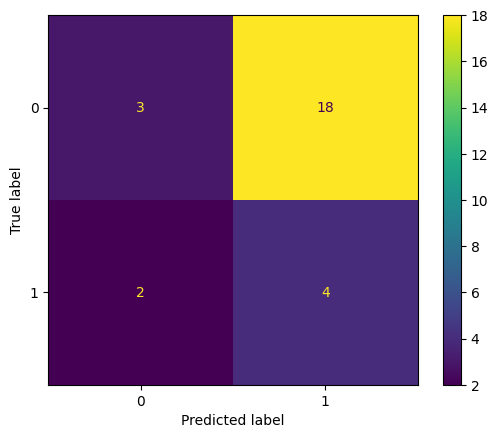

[N=1, P=2] Accuracy: 22.22%


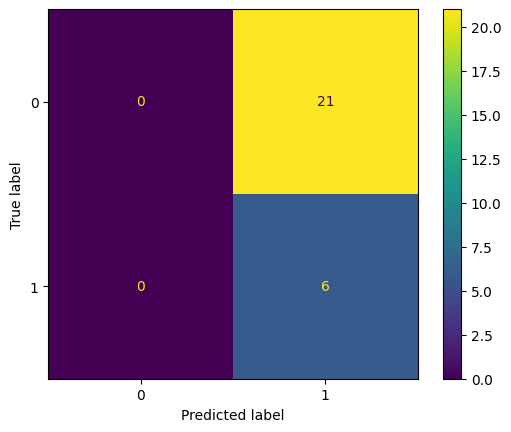

[N=2, P=2] Accuracy: 22.22%


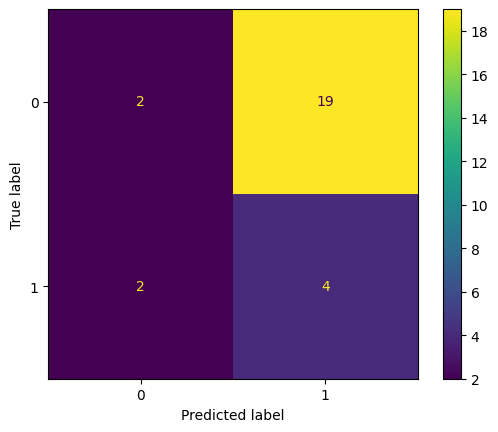

In [24]:
%run -i "../utils.py"
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_measurements = []
for n in [1, 2, 3, 4]:
    for p in [1, 2]:
        m = measure_method_by_threshold(
            output_fp=f"./ScoredBaseline-1-N{n}P{p}.csv",
            output_threshold=300 if p == 1 else 15,
            reverse=True,
            verbose=False
        )
        all_measurements.append((f"[N={n}, P={p}]", m))

all_measurements.sort(key=lambda m: m[1]['accuracy'], reverse=True)
for m in all_measurements:
    print(f"{m[0]} Accuracy: {m[1]['accuracy']* 100:.2f}%")
    cm = ConfusionMatrixDisplay(confusion_matrix=m[1]['confusion_matrix'])
    cm.plot()
    plt.show()